# Semantic Segmentation Practice

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext ipython_unittest

import os, sys
import matplotlib.pyplot as plt
import unittest
import numpy as np
import utils
import torch
import torch.nn.functional as F

## Dataset

<img src='./resources/simdata.png' width='40%' align='left'/>

### Create Datasets

In [2]:
from datasets.simulation import SimDataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(2000, transform=transform)
val_set = SimDataset(200, transform=transform)

image_datasets = {
    'train': train_set, 
    'val': val_set
}

### Explore SimDataset

In [3]:
image, mask = train_set[0]
print("Image Size: {}".format(image.size()))
print("Mask Size: {}".format(mask.shape))
print("Number of Classes: {}".format(mask.shape[0]))

Image Size: torch.Size([3, 128, 128])
Mask Size: (5, 128, 128)
Number of Classes: 5


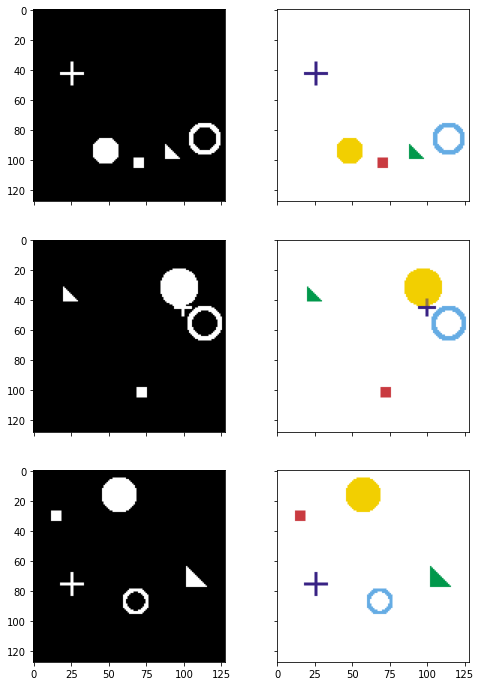

In [4]:
num_to_show = 3
input_images, target_masks = zip(*[train_set.get_raw_item(i) for i in range(num_to_show)])

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [utils.masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask (Ground-truth)
utils.plot_side_by_side([input_images_rgb, target_masks_rgb])

# Loss

### Let's Implement Dice Loss

<img src='./resources/dice.png' width='40%' align='left'/>

In [12]:
def dice_loss_with_logits2(logits: torch.Tensor, target: torch.Tensor, smooth=1.):
    """
    logits' size = (batch_size, num_class, H, W)
    targets' size = (batch_size, num_class, H, W)
    """
    pred = torch.softmax(logits, dim=1)
    target = target.contiguous()

    intersection = ?

    loss = ?

    return loss.mean()

SyntaxError: invalid syntax (<ipython-input-12-8b9d05f576d7>, line 9)

In [13]:
%%unittest_main
import numpy as np
from losses import dice_loss_with_logits


def create_random_targets(*shape):
    batch_size, num_class, H, W = shape
    eye = torch.eye(num_class)
    return eye[np.random.choice(num_class, batch_size * H * W)].view(batch_size, num_class, H, W)
    
def is_almost_equel(tens_a, tens_b, delta=1e-5):
    return torch.all(torch.lt(torch.abs(torch.add(tens_a, -tens_b)), delta))

class TestDiceLoss(unittest.TestCase):
    def setUp(self):
        self.batch_size = 3
        self.num_class = 5
        self.image_size = (10, 10)
        
    def test_dice_loss(self):
        logits = torch.randn(self.batch_size, self.num_class, *self.image_size)
        targets = create_random_targets(self.batch_size, self.num_class, *self.image_size)
        
        self.assertTrue(is_almost_equel(dice_loss_with_logits(logits, targets), dice_loss_with_logits2(logits, targets)))

Success

.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

# Model: FCN 4s

### Fusion : Matching Channel Size + Addition

In [126]:
import torch.nn as nn
from torchvision import models


class Fusion(nn.Module):
    def __init__(self, upper_channel_size: int, lower_channel_size: int):
        super().__init__()
        self.conv = nn.Conv2d(upper_channel_size, lower_channel_size, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, upper_feature_map: torch.Tensor, lower_feature_map: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

In [63]:
%%unittest_main


class TestFusion(unittest.TestCase):
    def setUp(self):
        self.batch_size = 5
        self.feature_height = 32
        self.feature_width = 32
        self.epsilon = 1e-4
    
    def test_fused_feature_size_should_be_equal_to_lower_feature_map_size(self):
        upper_feature_channel_size = 64
        lower_feature_channel_size = 32

        upper_features = torch.randn(self.batch_size, upper_feature_channel_size, self.feature_height, self.feature_width)
        lower_features = torch.randn(self.batch_size, lower_feature_channel_size, self.feature_height, self.feature_width)
        
        fusion = Fusion(upper_feature_channel_size, lower_feature_channel_size)
        fused_features = fusion(upper_features, lower_features)
        self.assertTupleEqual(lower_features.size(), fused_features.size())
        
    def test_fused_feature_values(self):
        upper_feature_channel_size = 128
        lower_feature_channel_size = 64

        upper_features = torch.randn(self.batch_size, upper_feature_channel_size, self.feature_height, self.feature_width)
        lower_features = torch.randn(self.batch_size, lower_feature_channel_size, self.feature_height, self.feature_width)
        
        fusion = Fusion(upper_feature_channel_size, lower_feature_channel_size)
        fused_features = fusion(upper_features, lower_features)
        self.assertTupleEqual(lower_features.size(), fused_features.size())
        self.assertEqual(lower_features.numel(), 
                         torch.sum(fused_features + self.epsilon > fusion.conv(upper_features) + lower_features))   

Success

..
----------------------------------------------------------------------
Ran 2 tests in 0.024s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

### Coding the FCN 4s

In [54]:
class FCN4s(nn.Module):

    def __init__(self, n_class, fusion_cls=Fusion):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)

        layers = list(self.base_model.children())
        self.layer1 = nn.Sequential(*layers[:5])  # size=(N, 64, x.H/4, x.W/4)
        self.layer2 = layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer3 = layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer4 = layers[7]  # size=(N, 512, x.H/32, x.W/32)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.fuse_fm4_and_fm3 = fusion_cls(512, 256)
        self.fuse_fm3_and_fm2 = fusion_cls(256, 128)
        self.fuse_fm2_and_fm1 = fusion_cls(128, 64)

        self.conv1k = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        fm1 = self.layer1(x)  # size=(N, 64, x.H/4, x.W/4)
        fm2 = self.layer2(fm1)  # size=(N, 128, x.H/8, x.W/8)
        fm3 = self.layer3(fm2)  # size=(N, 256, x.H/16, x.W/16)
        fm4 = self.layer4(fm3)  # size=(N, 512, x.H/32, x.W/32)

        up4 = ?  # size=(N, 512, x.H/16, x.W/16)
        fs43 = ?  # size=(N, 256, x.H/16, x.W/16)

        up3 = ?  # size=(N, 256, x.H/8, x.W/8)
        fs32 = ?  # size=(N, 128, x.H/8, x.W/8)

        up2 = ?  # size=(N, 128, x.H/4, x.W/4)
        fs21 = ?  # size=(N, 64, x.H/4, x.W/4)

        up1 = ?  # size=(N, 64, x.H/2, x.W/2)
        up1 = ?  # size=(N, 64, x.H, x.W)
        return self.conv1k(up1)  # size=(N, n_classes, x.H, x.W)


In [64]:
%%unittest_main


class TestFCN4s(unittest.TestCase):
    def test_fcn4s_output_size1(self):
        batch_size = 3
        num_channel, image_H, image_W = 3, 128, 128
        n_class = 5
        
        inputs = torch.randn(batch_size, num_channel, image_H, image_W)
        model = FCN4s(n_class=n_class)
        outputs = model(inputs)
        self.assertTupleEqual((batch_size, n_class, image_H, image_W), outputs.size())
        
    def test_fcn4s_output_size2(self):
        batch_size = 5
        num_channel, image_H, image_W = 3, 64, 64
        n_class = 12
        
        inputs = torch.randn(batch_size, num_channel, image_H, image_W)
        model = FCN4s(n_class=n_class)
        outputs = model(inputs)
        self.assertTupleEqual((batch_size, n_class, image_H, image_W), outputs.size()) 

Success

..
----------------------------------------------------------------------
Ran 2 tests in 0.707s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

# Train FCN 4s

<img src='./resources/fcn.png' width='80%' align='left'/>

## Trainer

In [81]:
import copy
import time

import torch
import torch.nn.functional as F

from losses import dice_loss_with_logits
from metric import AverageMeterSet


def print_metrics(phase, average_meter_set: AverageMeterSet):
    results = ["{}: {:4f}".format(k, v) for k, v in average_meter_set.averages().items()]
    print("{}: {}".format(phase, ", ".join(results)))


def train_one_epoch(model, dataloader, optimizer, device, bce_weight=0.5):
    average_meter_set = AverageMeterSet()
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        targets = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        logits = model(inputs)

        bce_loss = F.binary_cross_entropy_with_logits(logits, targets)
        dice_loss = dice_loss_with_logits(logits, targets)

        loss = bce_loss * bce_weight + dice_loss * (1 - bce_weight)

        loss.backward()
        optimizer.step()

        average_meter_set.update('bce_loss', bce_loss.item())
        average_meter_set.update('dice_loss', dice_loss.item())
        average_meter_set.update('loss', loss.item())

    return average_meter_set, model


def validate(model, dataloader, device, bce_weight=0.5):
    average_meter_set = AverageMeterSet()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            targets = labels.to(device)

            logits = model(inputs)

            bce_loss = F.binary_cross_entropy_with_logits(logits, targets)
            dice_loss = dice_loss_with_logits(logits, targets)

            loss = bce_loss * bce_weight + dice_loss * (1 - bce_weight)

            average_meter_set.update('bce_loss', bce_loss.item())
            average_meter_set.update('dice_loss', dice_loss.item())
            average_meter_set.update('loss', loss.item())

    return average_meter_set


def train_model(model, dataloaders, optimizer, lr_scheduler, device, bce_weight=0.5, num_epochs=25):
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                average_meter_set, model = train_one_epoch(model, dataloaders[phase], optimizer, device, bce_weight)
                print_metrics(phase, average_meter_set)
                lr_scheduler.step()
            else:
                model.eval()  # Set model to evaluate mode
                average_meter_set = validate(model, dataloaders[phase], device, bce_weight)
                print_metrics(phase, average_meter_set)
                epoch_loss = average_meter_set.averages()['loss']

                if epoch_loss < best_loss:
                    print("Saving the Best Model")
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Training Configurations

In [74]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 25
n_class = 5
bce_weight = 0.5

### DataLoader

In [17]:
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2000, 'val': 200}

In [22]:
def reverse_transform(inp: torch.Tensor):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

Inputs' Size should be [batch_size, num_channel, height, width]: torch.Size([25, 3, 128, 128])
Masks' Size should be [batch_size, num_classes, height, width]: torch.Size([25, 5, 128, 128])
0.0 1.0 0.0446875 0.20661686
0.0 1.0 0.009103515 0.09497706


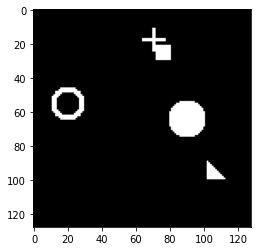

In [23]:
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print("Inputs' Size should be [batch_size, num_channel, height, width]: {}".format(inputs.shape))
print("Masks' Size should be [batch_size, num_classes, height, width]: {}".format(masks.shape))

for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[3]))

### Create Model, Optimizer, Learning Rate Scheduler

In [76]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

fcn = FCN4s(n_class=n_class)
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(fcn.parameters(), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

### Let's Train

In [82]:
fcn = train_model(fcn, dataloaders, optimizer_ft, exp_lr_scheduler, device, bce_weight, num_epochs=25)

Epoch 0/24
----------
LR 0.001
train: bce_loss: 0.020979, dice_loss: 0.341017, loss: 0.180998
val: bce_loss: 0.017343, dice_loss: 0.334135, loss: 0.175739
Saving the Best Model
0m 3s
Epoch 1/24
----------
LR 0.001
train: bce_loss: 0.016619, dice_loss: 0.315031, loss: 0.165825
val: bce_loss: 0.015759, dice_loss: 0.308241, loss: 0.162000
Saving the Best Model
0m 3s
Epoch 2/24
----------
LR 0.001
train: bce_loss: 0.014077, dice_loss: 0.296749, loss: 0.155413
val: bce_loss: 0.015003, dice_loss: 0.299612, loss: 0.157308
Saving the Best Model
0m 3s
Epoch 3/24
----------
LR 0.001
train: bce_loss: 0.012620, dice_loss: 0.288384, loss: 0.150502
val: bce_loss: 0.014716, dice_loss: 0.295929, loss: 0.155323
Saving the Best Model
0m 3s
Epoch 4/24
----------
LR 0.001
train: bce_loss: 0.011785, dice_loss: 0.278702, loss: 0.145244
val: bce_loss: 0.011436, dice_loss: 0.283207, loss: 0.147322
Saving the Best Model
0m 3s
Epoch 5/24
----------
LR 0.001
train: bce_loss: 0.011034, dice_loss: 0.274486, loss: 

### Visualizing the Results

(3, 5, 128, 128)


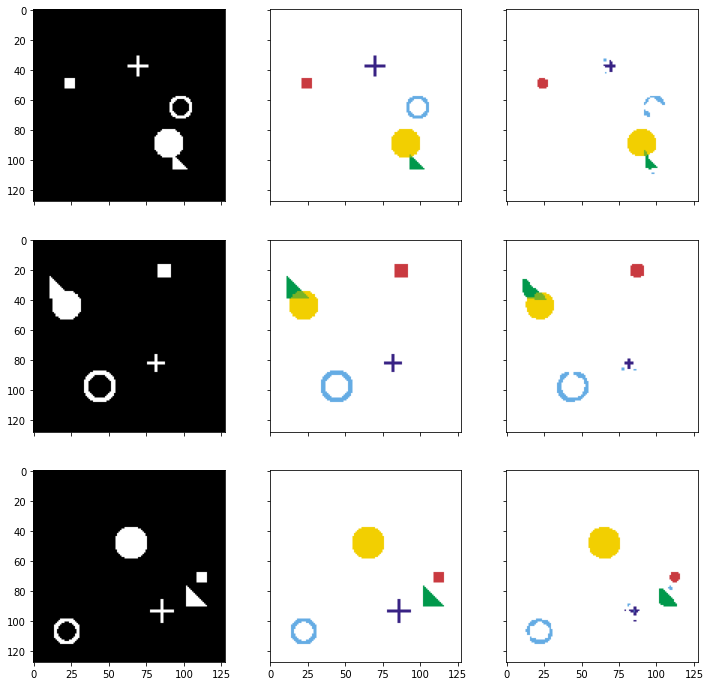

In [84]:
# prediction

import math

fcn.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = transform)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = fcn(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [utils.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [utils.masks_to_colorimg(x) for x in pred]

utils.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

# Train UNet


<img src='./resources/unet.png' width='80%' align='middle'/>

In [104]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

In [112]:
class Fusion2(nn.Module):
    def __init__(self, upper_channel_size: int, lower_channel_size: int):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up = double_conv(upper_channel_size + lower_channel_size, lower_channel_size)

    def forward(self, upper_feature_map: torch.Tensor, lower_feature_map: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

In [113]:
%%unittest_main


class TestFusion2(unittest.TestCase):
    def setUp(self):
        self.batch_size = 5
        self.upper_feature_size = 32
        self.lower_feature_size = 64
        self.epsilon = 1e-4
    
    def test_fused_feature_size_should_be_equal_to_lower_feature_map_size(self):
        upper_feature_channel_size = 256
        lower_feature_channel_size = 128

        upper_features = torch.randn(self.batch_size, upper_feature_channel_size, self.upper_feature_size, self.upper_feature_size)
        lower_features = torch.randn(self.batch_size, lower_feature_channel_size, self.lower_feature_size, self.lower_feature_size)
        
        fusion = Fusion2(upper_feature_channel_size, lower_feature_channel_size)
        fused_features = fusion(upper_features, lower_features)
        self.assertTupleEqual(lower_features.size(), fused_features.size())

Success

.
----------------------------------------------------------------------
Ran 1 test in 0.188s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [117]:
import torch
import torch.nn as nn


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        
        self.fuse_up3 = Fusion2(512, 256)
        self.fuse_up2 = Fusion2(256, 128)
        self.fuse_up1 = Fusion2(128, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        conv1 = ? # size=(N, 64, x.H, x.W)
        x = ?  # size=(N, 64, x.H/2, x.W/2)

        conv2 = ?  # size=(N, 128, x.H/2, x.W/2)
        x = ?  # size=(N, 128, x.H/4, x.W/4)

        conv3 = ?  # size=(N, 256, x.H/4, x.W/4)
        x = ?  # size=(N, 256, x.H/8, x.W/8)

        conv4 = ?  # size=(N, 512, x.H/8, x.W/8)
        
        x = ?  # size=(N, 256, x.H/4, x.W/4)
        x = ?  # size=(N, 128, x.H/2, x.W/2)
        x = ?  # size=(N, 64, x.H, x.W)
        
        out = ?  # size=(N, n_class, x.H, x.W)
        return out

In [121]:
%%unittest_main


class TestUNet(unittest.TestCase):
    def test_unet_output_size1(self):
        batch_size = 3
        num_channel, image_H, image_W = 3, 128, 128
        n_class = 5
        
        inputs = torch.randn(batch_size, num_channel, image_H, image_W)
        model = UNet(n_class=n_class)
        outputs = model(inputs)
        self.assertTupleEqual((batch_size, n_class, image_H, image_W), outputs.size())
        
    def test_unet_output_size2(self):
        batch_size = 5
        num_channel, image_H, image_W = 3, 64, 64
        n_class = 12
        
        inputs = torch.randn(batch_size, num_channel, image_H, image_W)
        model = UNet(n_class=n_class)
        outputs = model(inputs)
        self.assertTupleEqual((batch_size, n_class, image_H, image_W), outputs.size()) 

Success

..
----------------------------------------------------------------------
Ran 2 tests in 0.495s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

### Create Model, Optimizer, Learning Rate Scheduler

In [122]:
unet = UNet(n_class=n_class)

optimizer_ft = optim.Adam(unet.parameters(), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

In [123]:
unet = train_model(unet, dataloaders, optimizer_ft, exp_lr_scheduler, device, bce_weight, num_epochs=25)

Epoch 0/24
----------
LR 0.001
train: bce_loss: 0.170005, dice_loss: 0.899894, loss: 0.534950
val: bce_loss: 0.021698, dice_loss: 0.728167, loss: 0.374932
Saving the Best Model
0m 11s
Epoch 1/24
----------
LR 0.001
train: bce_loss: 0.020875, dice_loss: 0.514395, loss: 0.267635
val: bce_loss: 0.012755, dice_loss: 0.335784, loss: 0.174270
Saving the Best Model
0m 11s
Epoch 2/24
----------
LR 0.001
train: bce_loss: 0.007894, dice_loss: 0.274425, loss: 0.141160
val: bce_loss: 0.006428, dice_loss: 0.256019, loss: 0.131224
Saving the Best Model
0m 12s
Epoch 3/24
----------
LR 0.001
train: bce_loss: 0.004569, dice_loss: 0.238360, loss: 0.121465
val: bce_loss: 0.004254, dice_loss: 0.240172, loss: 0.122213
Saving the Best Model
0m 12s
Epoch 4/24
----------
LR 0.001
train: bce_loss: 0.004055, dice_loss: 0.236214, loss: 0.120134
val: bce_loss: 0.003238, dice_loss: 0.235408, loss: 0.119323
Saving the Best Model
0m 12s
Epoch 5/24
----------
LR 0.001
train: bce_loss: 0.003047, dice_loss: 0.227194, l

### Visualizing the Results

(3, 5, 128, 128)


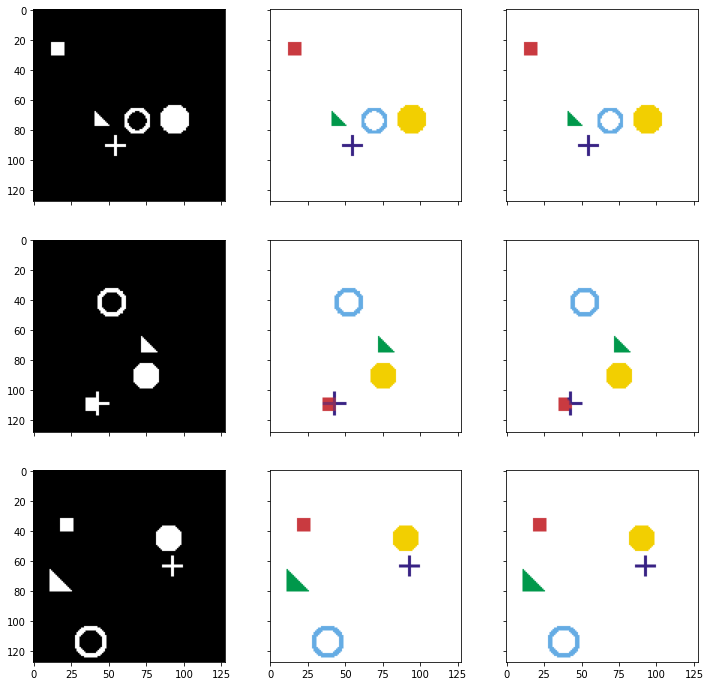

In [125]:
# prediction

import math

unet.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = transform)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = unet(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [utils.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [utils.masks_to_colorimg(x) for x in pred]

utils.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])